<a href="https://colab.research.google.com/github/Monaa48/Hands-On-Machine-Learning-with-Scikit-Learn-Keras-and-TensorFlow/blob/main/notebooks/ch07_ensemble_learning_random_forests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 07 — Ensemble Learning and Random Forests

## 1) Summary
### 1.1 Why ensembles work
An **ensemble** combines multiple models (often called *estimators*) to improve performance:
- **Reduce variance**: averaging many high-variance models (e.g., decision trees) makes predictions more stable.
- **Reduce bias**: boosting can build a strong predictor by adding weak learners sequentially.
- **Improve robustness**: diverse errors can cancel out when aggregated.

A key requirement is **diversity** among estimators (different errors). Typical ways to create diversity:
- Different random subsets of the training set (bagging / pasting)
- Different random subsets of features (random forests)
- Sequential focus on previous mistakes (boosting)
- Different model families (voting / stacking)

### 1.2 Main ensemble families in this chapter
**A) Voting**
- Combine predictions from different trained models.
- **Hard voting**: majority class label.
- **Soft voting**: average predicted class probabilities, then pick the class with the highest average probability.
  Soft voting usually works well when classifiers are well-calibrated and support `predict_proba()`.

**B) Bagging (Bootstrap Aggregating)**
- Train the same model on many bootstrap samples (sampling with replacement).
- Typical base estimator: decision trees.
- Helps mainly with **variance reduction**.
- **OOB (Out-of-Bag)** evaluation can estimate generalization without a separate validation set.

**C) Random Forests**
- Bagging + extra randomness in **feature selection per split**.
- Further increases estimator diversity → often better generalization.
- Provides **feature importance** estimates (based on impurity decrease).

**D) Extra-Trees (Extremely Randomized Trees)**
- Like random forests but uses more random split thresholds.
- Often faster and can reduce variance further, but may increase bias.

**E) Boosting**
- Build an ensemble **sequentially**, where each new model focuses on previous errors.
- **AdaBoost**: increases weight on misclassified instances; often uses decision stumps.
- **Gradient Boosting**: each new model fits the residual errors (gradient step in function space).
- Key trade-off: **learning_rate vs n_estimators** (small learning rate + more trees often generalizes better).

**F) Stacking (brief)**
- Train several base models, then train a **meta-model** that learns how to combine their predictions.

### 1.3 What you will implement in this notebook
- VotingClassifier (hard/soft)
- BaggingClassifier + OOB score
- RandomForestClassifier + feature importances
- ExtraTreesClassifier
- AdaBoostClassifier
- GradientBoosting (regression example + early stopping idea)

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons, load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error

In [2]:
def plot_decision_regions(clf, X, y, axes, title=None, grid_steps=250):
    x0s = np.linspace(axes[0], axes[1], grid_steps)
    x1s = np.linspace(axes[2], axes[3], grid_steps)
    x0, x1 = np.meshgrid(x0s, x1s)
    X_grid = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X_grid).reshape(x0.shape)

    plt.contourf(x0, x1, y_pred, alpha=0.2)
    plt.contour(x0, x1, y_pred, colors="k", linewidths=0.5)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=12)
    plt.xlabel("x1")
    plt.ylabel("x2")
    if title:
        plt.title(title)

## 2) Dataset Setup (Classification)

We will use two datasets:
- **make_moons (2D)** for decision boundary visualization.
- **Breast Cancer Wisconsin** for a more realistic tabular classification benchmark.

We keep evaluation simple and reproducible with train/test split and (optionally) cross-validation.

In [3]:
X_moons, y_moons = make_moons(n_samples=2000, noise=0.25, random_state=42)
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    X_moons, y_moons, test_size=0.2, random_state=42, stratify=y_moons
)

cancer = load_breast_cancer()
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    cancer.data, cancer.target, test_size=0.2, random_state=42, stratify=cancer.target
)

(X_train_m.shape, X_test_m.shape), (X_train_c.shape, X_test_c.shape)

(((1600, 2), (400, 2)), ((455, 30), (114, 30)))

## 3) Voting Classifier

### 3.1 Theory (concise)
- **Hard voting**: pick the class predicted by the majority of classifiers.
- **Soft voting**: average predicted probabilities and pick the argmax.
Soft voting usually performs better if the individual classifiers are reasonably calibrated.

We combine:
- Logistic Regression (linear baseline)
- Random Forest (nonlinear, variance-reducing ensemble)
- SVC with probability enabled (nonlinear margin-based classifier)

We evaluate on the breast cancer dataset.

In [4]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

log_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=5000, random_state=42))
])

rnd_clf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)

svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="rbf", C=5, gamma="scale", probability=True, random_state=42))
])

voting_hard = VotingClassifier(
    estimators=[("lr", log_clf), ("rf", rnd_clf), ("svm", svm_clf)],
    voting="hard"
)

voting_soft = VotingClassifier(
    estimators=[("lr", log_clf), ("rf", rnd_clf), ("svm", svm_clf)],
    voting="soft"
)

for clf in (log_clf, rnd_clf, svm_clf, voting_hard, voting_soft):
    clf.fit(X_train_c, y_train_c)
    y_pred = clf.predict(X_test_c)
    print(type(clf).__name__, "accuracy:", accuracy_score(y_test_c, y_pred))

Pipeline accuracy: 0.9824561403508771
RandomForestClassifier accuracy: 0.956140350877193
Pipeline accuracy: 0.9824561403508771
VotingClassifier accuracy: 0.9824561403508771
VotingClassifier accuracy: 0.9736842105263158


**Interpretation guide:**
- If the soft voting ensemble is better than most individual models, it suggests the models make **different errors** and probability averaging helps.
- If it is not better, models may be too correlated, miscalibrated, or the dataset is already easy for a single strong model.

## 4) Bagging (Bootstrap Aggregating)

### 4.1 Theory (concise)
Bagging trains multiple estimators on **bootstrap samples** (sampling with replacement).
Predictions are aggregated (majority vote for classification, averaging for regression).

Key knobs:
- `n_estimators`: number of models
- `max_samples`: fraction/size of sample used per estimator
- `bootstrap`: True for bagging, False for pasting
- `oob_score`: out-of-bag evaluation as a built-in generalization estimate

We demonstrate bagging with decision trees on **make_moons**.

In [5]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=200,
    max_samples=0.8,
    bootstrap=True,
    oob_score=True,
    n_jobs=-1,
    random_state=42
)

bag_clf.fit(X_train_m, y_train_m)
y_pred = bag_clf.predict(X_test_m)

acc = accuracy_score(y_test_m, y_pred)
oob = bag_clf.oob_score_
acc, oob

(0.925, 0.950625)

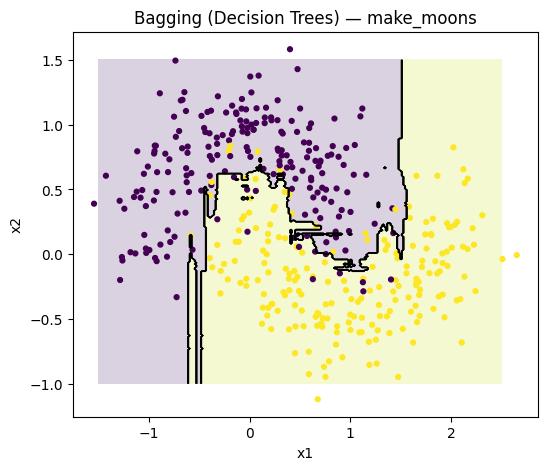

In [6]:
plt.figure(figsize=(6, 5))
plot_decision_regions(bag_clf, X_test_m, y_test_m, axes=[-1.5, 2.5, -1, 1.5], title="Bagging (Decision Trees) — make_moons")
plt.show()

## 5) Random Forests

### 5.1 Theory (concise)
Random Forest = Bagging + random feature selection at each split.
This increases diversity and typically reduces variance further.

Random forests also provide **feature_importances_** (impurity-based). This is a fast heuristic for feature relevance.

In [7]:
rf_clf = RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1)
rf_clf.fit(X_train_c, y_train_c)
rf_acc = accuracy_score(y_test_c, rf_clf.predict(X_test_c))
rf_acc

0.956140350877193

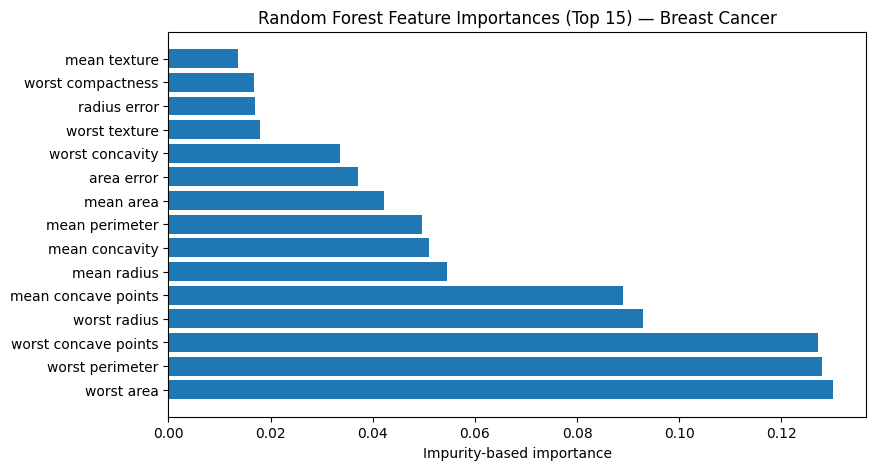

In [8]:
# Feature importances (top 15)
importances = rf_clf.feature_importances_
indices = np.argsort(importances)[::-1]

top_k = 15
top_features = [cancer.feature_names[i] for i in indices[:top_k]]
top_importances = importances[indices[:top_k]]

plt.figure(figsize=(9, 5))
plt.barh(range(top_k)[::-1], top_importances[::-1])
plt.yticks(range(top_k)[::-1], top_features[::-1])
plt.xlabel("Impurity-based importance")
plt.title("Random Forest Feature Importances (Top 15) — Breast Cancer")
plt.show()

**Note:** impurity-based importances can be biased toward features with many unique values.
Permutation importance (later / optional) is often more reliable for some use cases.

## 6) Extra-Trees (Extremely Randomized Trees)

### 6.1 Theory (concise)
Extra-Trees inject more randomness:
- Random feature selection (like RF)
- Random split thresholds (more randomized than RF)

Often:
- faster training
- similar or better generalization in some datasets

In [9]:
from sklearn.ensemble import ExtraTreesClassifier

extra_clf = ExtraTreesClassifier(n_estimators=500, random_state=42, n_jobs=-1)
extra_clf.fit(X_train_c, y_train_c)
extra_acc = accuracy_score(y_test_c, extra_clf.predict(X_test_c))
extra_acc

0.956140350877193

## 7) AdaBoost

### 7.1 Theory (concise)
AdaBoost builds an ensemble sequentially.
Each new weak learner focuses more on instances that were misclassified previously.

Common base estimator: decision stump (a tree with `max_depth=1`).
Key knobs:
- `n_estimators`
- `learning_rate`

In [10]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1, random_state=42),
    n_estimators=200,
    learning_rate=0.5,
    random_state=42
)

ada_clf.fit(X_train_m, y_train_m)
ada_acc = accuracy_score(y_test_m, ada_clf.predict(X_test_m))
ada_acc

0.9275

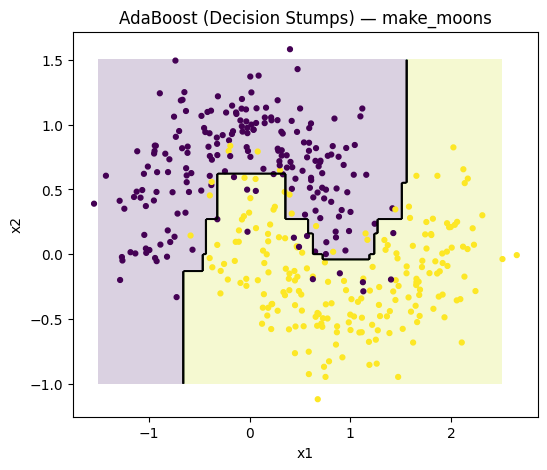

In [11]:
plt.figure(figsize=(6, 5))
plot_decision_regions(ada_clf, X_test_m, y_test_m, axes=[-1.5, 2.5, -1, 1.5], title="AdaBoost (Decision Stumps) — make_moons")
plt.show()

## 8) Gradient Boosting (Regression demo + Early Stopping idea)

### 8.1 Theory (concise)
Gradient Boosting builds models sequentially; each new model fits the **residual errors** of the previous ensemble.

Key trade-offs:
- `learning_rate` (shrinkage): smaller values often need more estimators but can generalize better
- `n_estimators`: more trees increases capacity
- `max_depth` (or `max_leaf_nodes`): controls individual tree complexity
- `subsample` (stochastic gradient boosting): <1.0 adds randomness, can reduce variance

We show a regression example and use a simple early-stopping approach by monitoring validation RMSE.

In [12]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

np.random.seed(42)
m = 2000
X = np.random.rand(m, 1) * 6 - 3
y = (0.5 * X**2 + X + 2 + np.random.randn(m, 1)).ravel()

X_train_g, X_val_g, y_train_g, y_val_g = train_test_split(X, y, test_size=0.2, random_state=42)

gbrt = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=2,
    random_state=42
)

gbrt.fit(X_train_g, y_train_g)

# Early stopping via staged predictions
val_errors = []
for y_pred in gbrt.staged_predict(X_val_g):
    val_errors.append(mean_squared_error(y_val_g, y_pred))

best_n_estimators = np.argmin(val_errors) + 1
best_rmse = np.sqrt(val_errors[best_n_estimators - 1])

best_n_estimators, best_rmse

(np.int64(101), np.float64(1.0242873850722929))

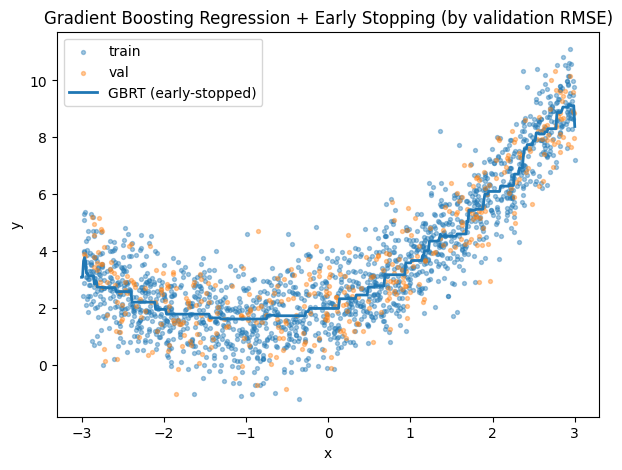

In [13]:
gbrt_best = GradientBoostingRegressor(
    n_estimators=best_n_estimators,
    learning_rate=0.05,
    max_depth=2,
    random_state=42
)
gbrt_best.fit(X_train_g, y_train_g)

X_new = np.linspace(-3, 3, 500).reshape(-1, 1)
y_pred_best = gbrt_best.predict(X_new)

plt.figure(figsize=(7, 5))
plt.scatter(X_train_g, y_train_g, s=8, alpha=0.4, label="train")
plt.scatter(X_val_g, y_val_g, s=8, alpha=0.4, label="val")
plt.plot(X_new, y_pred_best, linewidth=2, label="GBRT (early-stopped)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Gradient Boosting Regression + Early Stopping (by validation RMSE)")
plt.show()

## 9) (Brief) Stacking Concept

Stacking trains multiple base models, then trains a meta-model on their predictions.
In practice, stacking is powerful but must be implemented carefully to avoid data leakage:
- Use out-of-fold predictions for training the meta-model.

We do not implement stacking here to keep the notebook focused and lightweight.

## 10) Takeaways
- Ensembles improve performance mainly through **variance reduction** (bagging/RF) and/or **bias reduction** (boosting).
- **Voting** combines different model families; soft voting uses averaged probabilities.
- **Bagging** + OOB score provides a simple and effective approach to reduce variance.
- **Random Forests** add random feature selection per split; often a strong default model.
- **Extra-Trees** add more randomness; can be faster and sometimes more accurate.
- **Boosting (AdaBoost/Gradient Boosting)** builds models sequentially; tune `learning_rate` and `n_estimators` carefully.
- Early stopping for boosting is a practical regularization strategy.

## 11) References
- Aurélien Géron, *Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow*, Chapter 7.
- scikit-learn documentation: `VotingClassifier`, `BaggingClassifier`, `RandomForestClassifier`, `ExtraTreesClassifier`, `AdaBoostClassifier`, `GradientBoostingRegressor`.